# Trainable Low-rank RNNs Tutorial

This tutorial gives a starting guide on how to train low-rank RNNs on a task (here the Ctx aka Mante task), how to identify populations and how to resample networks based on a Gaussian mixture distribution.

In [2]:
import sys
sys.path.append('../')
from low_rank_rnns.modules import *
from low_rank_rnns import clustering, mante

In [3]:
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 19
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.labelpad'] = 10

# Instantiation of a network

The file `modules.py` contains 3 classes of networks:
* `FullRankRNN`
* `LowRankRNN`
* `SupportLowRankRNN`
as well as a train function that I will detail later. 

The 3 RNNs implement the equation:

$$\tau \dot{x}_i = -x_i + \sum_j J_{ij}x_j + \sigma \xi_i(t)$$

integrated as follows:

$$x_{t+1,i} = x_{t,i} + \frac{dt}{\tau}(-x_{t,i} + \sum_j J_{ij}x_{t,j}) + \sigma \xi_{t,i}$$

with $\xi_{t,i} \sim \mathcal{N}(0,1)$ being random white noise on the neural inputs.

The differences are in the definitions of the matrices, and the trainable parameters. For the full rank RNN, the parameters $J_{ij}$ are directly trainable, for the low rank RNN, they are defined as:

$J_{ij} = \sum_k m_i^{(k)}n_j^{(k)}$, where the $m_i$ and $n_j$ are trainable.

Finally the SupportLowRankRNN implements functionality to define networks from a Gaussian mixture distribution.

Let's define an instance of low-rank RNN:

In [4]:
input_size = 1
hidden_size = 500
output_size = 1
std_noise_rec = 5e-2
alpha = 0.2
rank = 1

net = LowRankRNN(input_size, hidden_size, output_size, std_noise_rec, alpha)

The mandatory arguments are :

* input_size: dimensionality of input,
* hidden_size: number of neurons,
* output_size: dimensionality of output,
* std_noise_rec: standard deviation of the white noise in the neurons
* alpha: value of $\frac{dt}{\tau}$ for integration of the differential equation
* rank: of course


# Training

The `train` function takes the arguments:
* net: the network to train
* input: a torch tensor of shape #trials x #timesteps x input_dimensionality
* target: a torch tensor of shape #trials x #timesteps x output_dimensionality
* mask: a torch tensor of shape #trials x #timesteps x 1. It specifies with parts of the target should matter to the network (the loss function will be computed only on the timesteps where mask is non zero)
* the number of epochs
* the learning rate (should be tuned, between 1e-4 and 1e-2 is usually good)
* some other arguments to check in `modules.py`. In particular, if you have a GPU, add `cuda=True`

The loss function is defined as (assuming a one dimensional output):

$$\mathcal{L} = \frac{1}{N}\sum_{i=1}^{N}\frac{\sum_{t=1}^{T_i}m_{i,t}(o_{i,t} - z_{i,t})^2}{\sum_{t=1}^{T_i}m_{i,t}}$$

where m is the mask, o the output and z the target. If the output dimensionality is larger than 1, in the numerator a mean over output dimension is taken.

Let us build our own training data to see how it is done (here we will already split it in training and validation data. These lines are a copy of `rdm.generate_rdm_data`):

In [5]:
from low_rank_rnns.rdm import total_duration, fixation_duration_discrete, stimulus_end, response_begin, SCALE
num_trials = 1000
std = 1e-1
fraction_validation_trials = .2
coherences = [-4, -2, -1, 1, 2, 4]

inputs = std * torch.randn((num_trials, total_duration, 1), dtype=torch.float32)
targets = torch.zeros((num_trials, total_duration, 1), dtype=torch.float32)
mask = torch.zeros((num_trials, total_duration, 1), dtype=torch.float32)

# For each trial, generate data with a random coherence
for i in range(num_trials):
    coh_current = coherences[int(np.random.rand() * len(coherences))]
    inputs[i, fixation_duration_discrete:stimulus_end, 0] += coh_current * SCALE
    targets[i, response_begin:, 0] = 1 if coh_current > 0 else -1
    mask[i, response_begin:, 0] = 1

# Split
split_at = num_trials - int(num_trials * fraction_validation_trials)
x_train, x_val = inputs[:split_at], inputs[split_at:]
y_train, y_val = targets[:split_at], targets[split_at:]
mask_train, mask_val = mask[:split_at], mask[split_at:]

Here is for example the input, target and mask for trial 0 (sometimes mask coincides with target here):

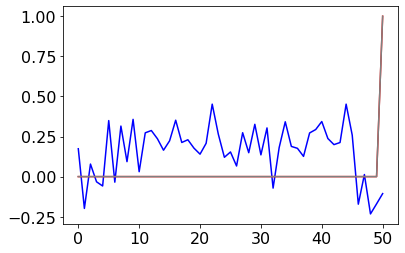

In [7]:
plt.plot(x_train[0, :, 0], c='b')
plt.plot(y_train[0, :, 0], c='r')
plt.plot(mask_train[0, :, 0], c='gray')

Training...
initial loss: 0.998
epoch 0:  loss=0.963  (took 0.78 s) *
epoch 1:  loss=0.657  (took 0.79 s) *
epoch 2:  loss=0.134  (took 0.77 s) *
epoch 3:  loss=0.053  (took 0.77 s) *
epoch 4:  loss=0.021  (took 0.76 s) *
epoch 5:  loss=0.008  (took 0.76 s) *


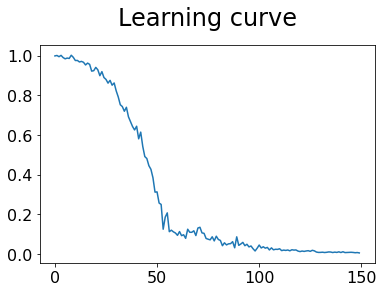

In [8]:
# Let's finally train! This task is very easy so a few epochs will do
train(net, x_train, y_train, mask_train, n_epochs=10, lr=1e-2, keep_best=True, clip_gradient=1, early_stop=0.01,
      plot_learning_curve=True)

Now we can test the performance of our network:

In [9]:
# Here we test the network on our left-out data
output = net.forward(x_val)
loss = loss_mse(output, y_val, mask_val)
print(f'Validated loss: {loss:.3f}')

# There is a general function for accuracy but don't trust it too much, better to write an ad-hoc one for each task
acc = accuracy_general(output, y_val, mask_val)
print(f'Validated accuracy: {acc:.3f}')

Validated loss: 0.006
Validated accuracy: 1.000


In [10]:
# This is how you extract the different vectors
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy()
wi = net.wi_full[0].detach().numpy()
wo = net.wo_full[:,0].detach().numpy()

In [11]:
# We can fit it with a gaussian (or a mixture of gaussians) and resample the network
net_res = clustering.to_support_net(net, np.zeros(hidden_size))  # This line creates a resampled network
# The second argument contains population labels. Here we have one population so labels are all zeros

output = net_res.forward(x_val)
loss = loss_mse(output, y_val, mask_val)
print(f'Loss of resampled network: {loss:.3f}')

# There is a general function for accuracy but don't trust it too much, better to write an ad-hoc one for each task
acc = accuracy_general(output, y_val, mask_val)
print(f'Accuracy: {acc:.3f}')

Loss of resampled network: 0.193
Accuracy: 1.000


In [10]:
# Example code to save or load a model (if you want to load a model, you will however to instatiate it first with
# the exact same parameters as when it was saved, so remember them!)
torch.save(net.state_dict(), 'example.pt')
net.load_state_dict(torch.load('example.pt'))

# Training on Mante and resampling

In [36]:
hidden_size = 1024
noise_std = 5e-2
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val = mante.generate_mante_data(1000, fraction_validation_trials=.2)
net = LowRankRNN(4, hidden_size, 1, noise_std, alpha, rank=1, train_wi=True)

Training...
initial loss: 0.992
epoch 0:  loss=0.947  (took 1.51 s) *
epoch 1:  loss=0.735  (took 1.54 s) *
epoch 2:  loss=0.636  (took 1.65 s) *
epoch 3:  loss=0.575  (took 1.64 s) *
epoch 4:  loss=0.608  (took 1.63 s)
epoch 5:  loss=0.585  (took 1.56 s)
epoch 6:  loss=0.590  (took 1.52 s)
epoch 7:  loss=0.586  (took 1.52 s)
epoch 8:  loss=0.602  (took 1.53 s)
epoch 9:  loss=0.564  (took 1.51 s) *
epoch 10:  loss=0.565  (took 1.52 s)
epoch 11:  loss=0.588  (took 1.56 s)
epoch 12:  loss=0.531  (took 1.64 s) *
epoch 13:  loss=0.550  (took 1.54 s)
epoch 14:  loss=0.565  (took 1.53 s)
epoch 15:  loss=0.558  (took 1.53 s)
epoch 16:  loss=0.494  (took 1.53 s) *
epoch 17:  loss=0.461  (took 1.64 s) *
epoch 18:  loss=0.432  (took 1.54 s) *
epoch 19:  loss=0.399  (took 1.51 s) *
epoch 20:  loss=0.315  (took 1.52 s) *
epoch 21:  loss=0.292  (took 1.52 s) *
epoch 22:  loss=0.257  (took 1.65 s) *
epoch 23:  loss=0.230  (took 1.56 s) *
epoch 24:  loss=0.171  (took 1.53 s) *
epoch 25:  loss=0.141  

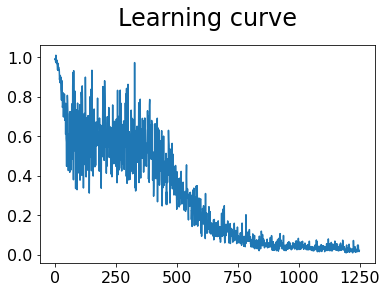

In [37]:
train(net, x_train, y_train, mask_train, n_epochs=50, lr=1e-2, keep_best=True, clip_gradient=.1, early_stop=0.01,
      plot_learning_curve=True)

In [42]:
loss_orig, acc_orig = mante.test_mante(net, x_val, y_val, mask_val)
print(loss_orig)
print(acc_orig)

0.024792511016130447
1.0


In [43]:
# This is how you would fit 2 populations
n_pops = 2
vecs = clustering.make_vecs(net)  # this line extracts the vectors m, n, wi, wo in a single list
z, _ = clustering.gmm_fit(vecs, n_pops, algo='bayes', random_state=2020)  # z will contain labels for the 2 populations

(array([0, 1]), array([639, 385]))
pop 0: slope=0.47, intercept=0.03
pop 1: slope=-0.34, intercept=-0.03
pop 0: slope=-0.51, intercept=-0.05
pop 1: slope=0.57, intercept=-0.11


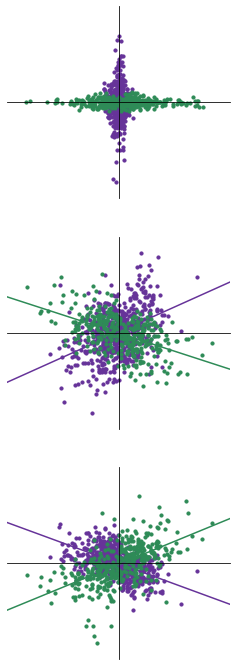

In [44]:
# Visualizing those 2 populations
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy()
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()
wi_ctx1 = net.wi[2].detach().numpy()
wi_ctx2 = net.wi[3].detach().numpy()
wo = net.wo[:,0].detach().numpy()
print(np.unique(z, return_counts=True))


fig, ax = plt.subplots(3, 1, figsize=(4, 12))
colors = ['rebeccapurple', 'seagreen']
fs = 12
clustering.pop_scatter_linreg(wi_ctx1, wi_ctx2, z, n_pops, colors=colors, linreg=False, ax=ax[0])
clustering.pop_scatter_linreg(n, wi1, z, n_pops, colors=colors, ax=ax[1])
clustering.pop_scatter_linreg(n, wi2, z, n_pops, colors=colors, ax=ax[2])

In [46]:
# This is how you would resample and retrain from the mixture of gaussians (not sure it will work)
net3 = clustering.to_support_net(net, z, new_size=4096)

# net3 here is an instance of SupportLowRankRNN, with trainable parameters of the mixture of gaussians
train(net3, x_train, y_train, mask_train, 20, lr=1e-6, resample=True, keep_best=True, clip_gradient=1)
accs2 = []
for _ in range(10):
    net3.resample_basis()
    loss, acc = mante.test_mante(net3, x_val, y_val, mask_val)
    accs2.append(acc)
print(accs2)

Training...
initial loss: 0.532
epoch 0:  loss=0.514  (took 3.75 s) *
epoch 1:  loss=0.504  (took 3.73 s) *
epoch 2:  loss=0.486  (took 3.75 s) *
epoch 3:  loss=0.422  (took 3.81 s) *
epoch 4:  loss=0.473  (took 3.85 s)
epoch 5:  loss=0.506  (took 3.83 s)
epoch 6:  loss=0.430  (took 4.18 s)
epoch 7:  loss=0.411  (took 5.12 s) *
epoch 8:  loss=0.450  (took 3.87 s)
epoch 9:  loss=0.399  (took 3.84 s) *
epoch 10:  loss=0.400  (took 3.84 s)
epoch 11:  loss=0.443  (took 3.93 s)
epoch 12:  loss=0.453  (took 3.94 s)
epoch 13:  loss=0.435  (took 3.85 s)
epoch 14:  loss=0.396  (took 3.91 s) *
epoch 15:  loss=0.463  (took 4.21 s)
epoch 16:  loss=0.413  (took 4.03 s)
epoch 17:  loss=0.410  (took 4.01 s)
epoch 18:  loss=0.384  (took 3.98 s) *
epoch 19:  loss=0.461  (took 4.02 s)
[0.8149999976158142, 0.9350000023841858, 0.8799999952316284, 0.8399999737739563, 0.8100000023841858, 0.9150000214576721, 0.9649999737739563, 0.8650000095367432, 0.875, 0.8399999737739563]
